In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
import scipy.stats as stats
import pymc as pm
import arviz as az
import pytensor
import pytensor.tensor as pt
from pytensor.tensor import TensorVariable
from scipy.stats import multivariate_normal, uniform
import math

# Defining distributions and pdfs

In [6]:
# mau
def sampleNormal(mean, cov):
    """
    mean: mean vector of dimension (d,)
    cov: covariance metrix of dimension (d,d)
    Returns a sample from an n-dimensional multivariate normal distribution and its log probability
    """
    rv = multivariate_normal(mean, cov)
    sample = rv.rvs()
    return sample

In [7]:
# mau
def getGMMPdf(means, covs, mixture_weights=None):
    """
    means: list of (d,) arrays
    covs: list of (d,d) arrays
    returns: pdf function
    """
    if mixture_weights is None:
        mixture_weights = [1/len(means)]*len(means)
    assert len(means) == len(covs) == len(mixture_weights)
    def pdf(pos):
        """
        pos: (n,d) array of points to evaluate the PDF at
        returns: (n,) array of floats
        """
        assert pos.shape[1] == means[0].shape[0]
        result = np.zeros((pos.shape[0],))
        for idx, mean in enumerate(means):
            rv = multivariate_normal(mean, covs[idx])
            result += mixture_weights[idx]*rv.pdf(pos)
        return result
    return pdf


In [8]:
# Function to generate a radially symmetric 2D GMM PDF with n modes of variance var
def getRadGMM2D(n, r, var):
    angles = np.linspace(0, 2*np.pi*((n-1)/n),n)
    return getGMMPdf(np.array([np.array([r*np.cos(ang),r*np.sin(ang)]) for ang in angles]),n*[var*np.eye(2)])

In [9]:
# Function to generate a symmetric truncated 2D-Gaussian PDF of dimension d with truncation radius c
def getTruncatedGaussian2D(c, var=1):
    """
    c: truncation radius
    returns: pdf function
    """
    normalizing_constant = 2*np.pi*var*np.exp(-c**2/(2*var))


    def pdf(x):
        """
        x: (n,2) array of points to evaluate the PDF at
        returns: (n,) array of floats
        """
        unnormalized_pdf = np.exp(-np.linalg.norm(x, axis=1)**2/(2*var))
        pdf_val = unnormalized_pdf / normalizing_constant
        return np.where(np.linalg.norm(x, axis=1) < c, 0, pdf_val)
    return pdf

# Plotting Util Functions

In [12]:
# Yield Plot For Square HeatMap
def plotSquareHeatmap2D(pdf, gridSize, lb, ub):
    x = np.linspace(lb, ub, gridSize)
    y = np.linspace(lb, ub, gridSize)
    fig, ax = plt.subplots(figsize=(10,6))

    out = np.ones((gridSize,gridSize))

    for i in range(gridSize):
        for j in range(gridSize):
            out[i][j] = pdf(np.array([[x[i],y[j]]]))
    # im1 = ax.imshow(out.T, cmap='viridis', interpolation='nearest', aspect='equal', extent=[lb,ub,lb,ub])
    im1 = ax.imshow(out, cmap='viridis', interpolation='nearest', aspect='equal', extent=[lb,ub,lb,ub])
    cbar = fig.colorbar(im1, ax=ax)
    ax.axis('equal')
    ax.set_xlabel(r'$\theta_{1}$')
    ax.set_ylabel(r'$\theta_{2}$')

    return fig, ax

# AIS Functions + Tests

In [52]:
# mau
def getUnnormalizedIntermediate(beta, initial, target, compose_type="exp"):
    """
    beta: float
    initial: pdf of initial distribution
    target: pdf of target distribution
    returns: unnormalized pdf of intermediate distribution
    """
    def unnormalizedPdf(x):
        """
        x: (n,d) array
        returns: (n,) array
        """
        if compose_type == "lin":
            return initial(x) + beta*(target(x) - initial(x))
        if compose_type == "exp":
            return initial(x)**(1-beta)*target(x)**beta
    return unnormalizedPdf

In [53]:
rv = multivariate_normal(np.array([1]), np.array([0.75]))
initial = rv.pdf
target = getGMMPdf([np.array([-1]), np.array([1])], [np.array([0.01]), np.array([0.01])])
beta_schedule = np.array([i/8 for i in range(16)])
beta_schedule = np.clip(beta_schedule, 0, 1)

In [56]:
# mau
def gaussianDriftMH(samples, beta, initial, target, var=0.1, compose_type="exp"):
    """
    samples: (n,d) array
    beta: float
    initial: pdf of initial distribution
    target: pdf of target distribution
    returns: (n,d) array
    """
    samples = samples.copy()
    n, d = samples.shape
    new_samples = np.apply_along_axis(lambda x: sampleNormal(x, var * np.eye(x.shape[0])), 1, samples).reshape((n, d))
    pdf = getUnnormalizedIntermediate(beta, initial, target, compose_type)
    old_probs = pdf(samples)
    new_probs = pdf(new_samples)
    rv = uniform()
    u = rv.rvs((samples.shape[0],))
    aux = u < new_probs/old_probs
    samples[aux] = new_samples[aux]
    return samples

In [72]:
# mau
def intermediateTransition(samples, beta, initial, target, k=5, transition_var=0.1, compose_type="exp"):
    """
    sample: (n,d) array
    beta: float
    initial: pdf of initial distribution
    target: pdf of target distribution
    returns: (n,d) array
    """
    for i in range(k):
        samples = gaussianDriftMH(samples, beta, initial, target, transition_var, compose_type)
    return samples

In [75]:
# mau
def AIS(beta_schedule, target, init_mean=np.array([0]), init_var=np.array([1]), n=2, k=5, transition_var=0.1, compose_type="exp"):
    """
    beta_schedule: list of floats from 0.0 to 1.0
    target: pdf of target distribution
    init_mean: (d,) array
    init_var: (d,d) array
    returns: (n,d) array and weight
    """
    rv = multivariate_normal(init_mean, init_var)
    initial = rv.pdf
    d = init_mean.shape[0]
    samples = rv.rvs(n).reshape((n,d))
    all_samples = [samples]
    log_weights = -np.log(initial(samples))

    for beta in beta_schedule[1:-1]:
        intermediate_pdf = getUnnormalizedIntermediate(beta, initial, target, compose_type)
        log_weights += np.log(intermediate_pdf(samples))
        samples = intermediateTransition(samples, beta, initial, target, k, transition_var, compose_type)
        all_samples.append(samples)
        log_weights -= np.log(intermediate_pdf(samples))
    
    intermediate_pdf = getUnnormalizedIntermediate(beta_schedule[-1], initial, target, compose_type)
    log_weights += np.log(intermediate_pdf(samples))
    return samples, np.exp(log_weights), all_samples

In [63]:
def ev(f, samples, weights):
    """
    f: function that takes in (n,d) array and outputs (n,) array
    samples: (n,d) array
    weights: (n,) array
    returns: (1,) array
    """
    return np.sum(f(samples) * weights)/np.sum(weights)

In [66]:
def effective_sample_size(weights):
    """
    weights: (n,) array
    returns: (1,) array
    """
    return np.sum(weights)**2/np.sum(weights**2)

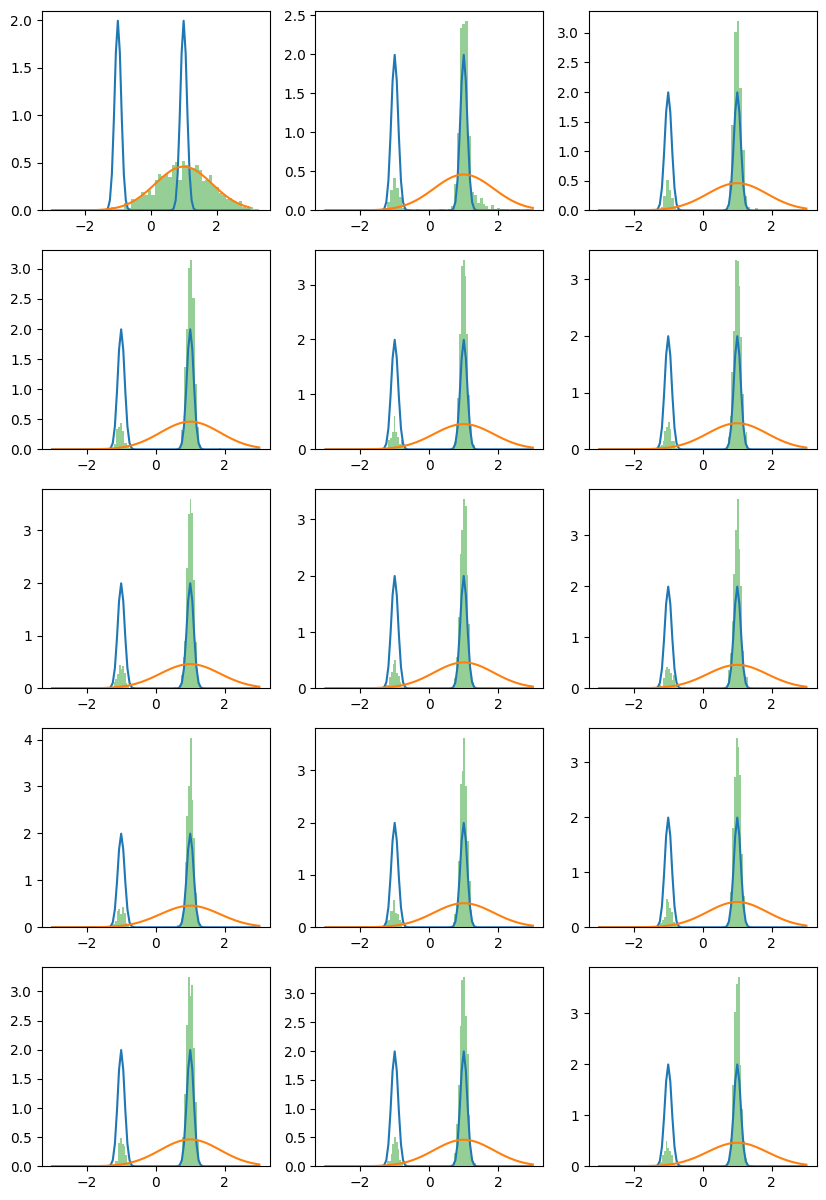

In [14]:
samples = multivariate_normal.rvs(np.array([1]), np.array([0.75]), 1000).reshape((1000,1))
fig, axs = plt.subplots(5,3, figsize=(10,15))

xs = np.linspace(-3, 3, 100).reshape((100,1))
for i in range(15):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    ax.plot(xs, target(xs), label='Target PDF')
    ax.plot(xs, initial(xs), label='Initial PDF')
    ax.hist(samples, bins=50, density=True, alpha=0.5)
    for _ in range(10):
        samples = gaussianDriftMH(samples, beta_schedule[-1], initial, target)
plt.savefig('mh.pdf')

In [15]:
samples, weights, all_samples = AIS([0.0, 1.0, 1.0], target, init_mean=np.array([1]), init_var=np.array([0.75]), n=1000, k=100)

In [16]:
effective_sample_size(weights)

41.4195669730532

In [17]:
var = lambda x, w: ev(lambda y: y[:,0]**2, x, w) - ev(lambda y: y[:,0], x, w)**2
print(var(samples, weights))
ev(lambda x: x[:,0], samples, weights)


0.9270530749934625


-0.3021010417231389

In [18]:
samples, weights, all_samples = AIS(beta_schedule, target, init_mean=np.array([1]), init_var=np.array([0.75]), n=1000, k=50)

In [19]:
effective_sample_size(weights)

111.0105804646373

In [20]:
var = lambda x, w: ev(lambda y: y[:,0]**2, x, w) - ev(lambda y: y[:,0], x, w)**2
print(var(samples, weights))
ev(lambda x: x[:,0], samples, weights)

1.026532554710162


-0.024466773746469255

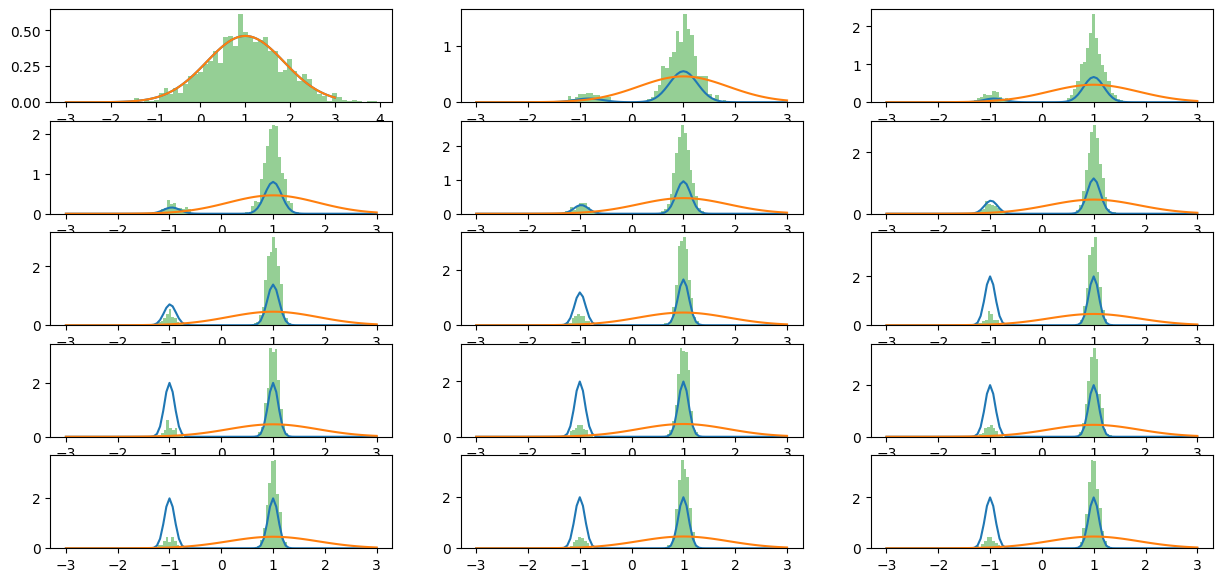

In [21]:
nrows = 5
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(15,7))


xs = np.linspace(-3, 3, 100).reshape((100,1))
for idx, beta in enumerate(beta_schedule[:-1]):
    row = idx // 3
    col = idx % 3
    ax = axs[row, col]
    pdf = getUnnormalizedIntermediate(beta, initial, target)
    ax.plot(xs, pdf(xs), label='Target PDF')
    ax.plot(xs, initial(xs), label='Initial PDF')
    ax.hist(all_samples[idx], density=True, bins=50, alpha=0.5, label='Samples')
plt.savefig('ais.pdf')

In [122]:
target = getRadGMM2D(6, 8, 1)
initial = multivariate_normal(np.array([0,0]), np.eye(2)).pdf
samples, weights, all_samples = AIS(beta_schedule, target, init_mean=np.array([0,0]), init_var=np.eye(2), n=1000, k=20)

Text(0, 0.5, '$\\theta_2$')

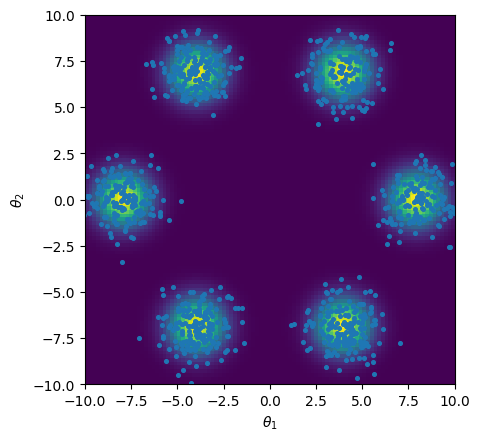

In [123]:
plt.scatter(samples[:,0], samples[:,1], alpha=1, s=7)
plt.imshow(target(xs).reshape(100,100), extent=[-10,10,-10,10])
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")

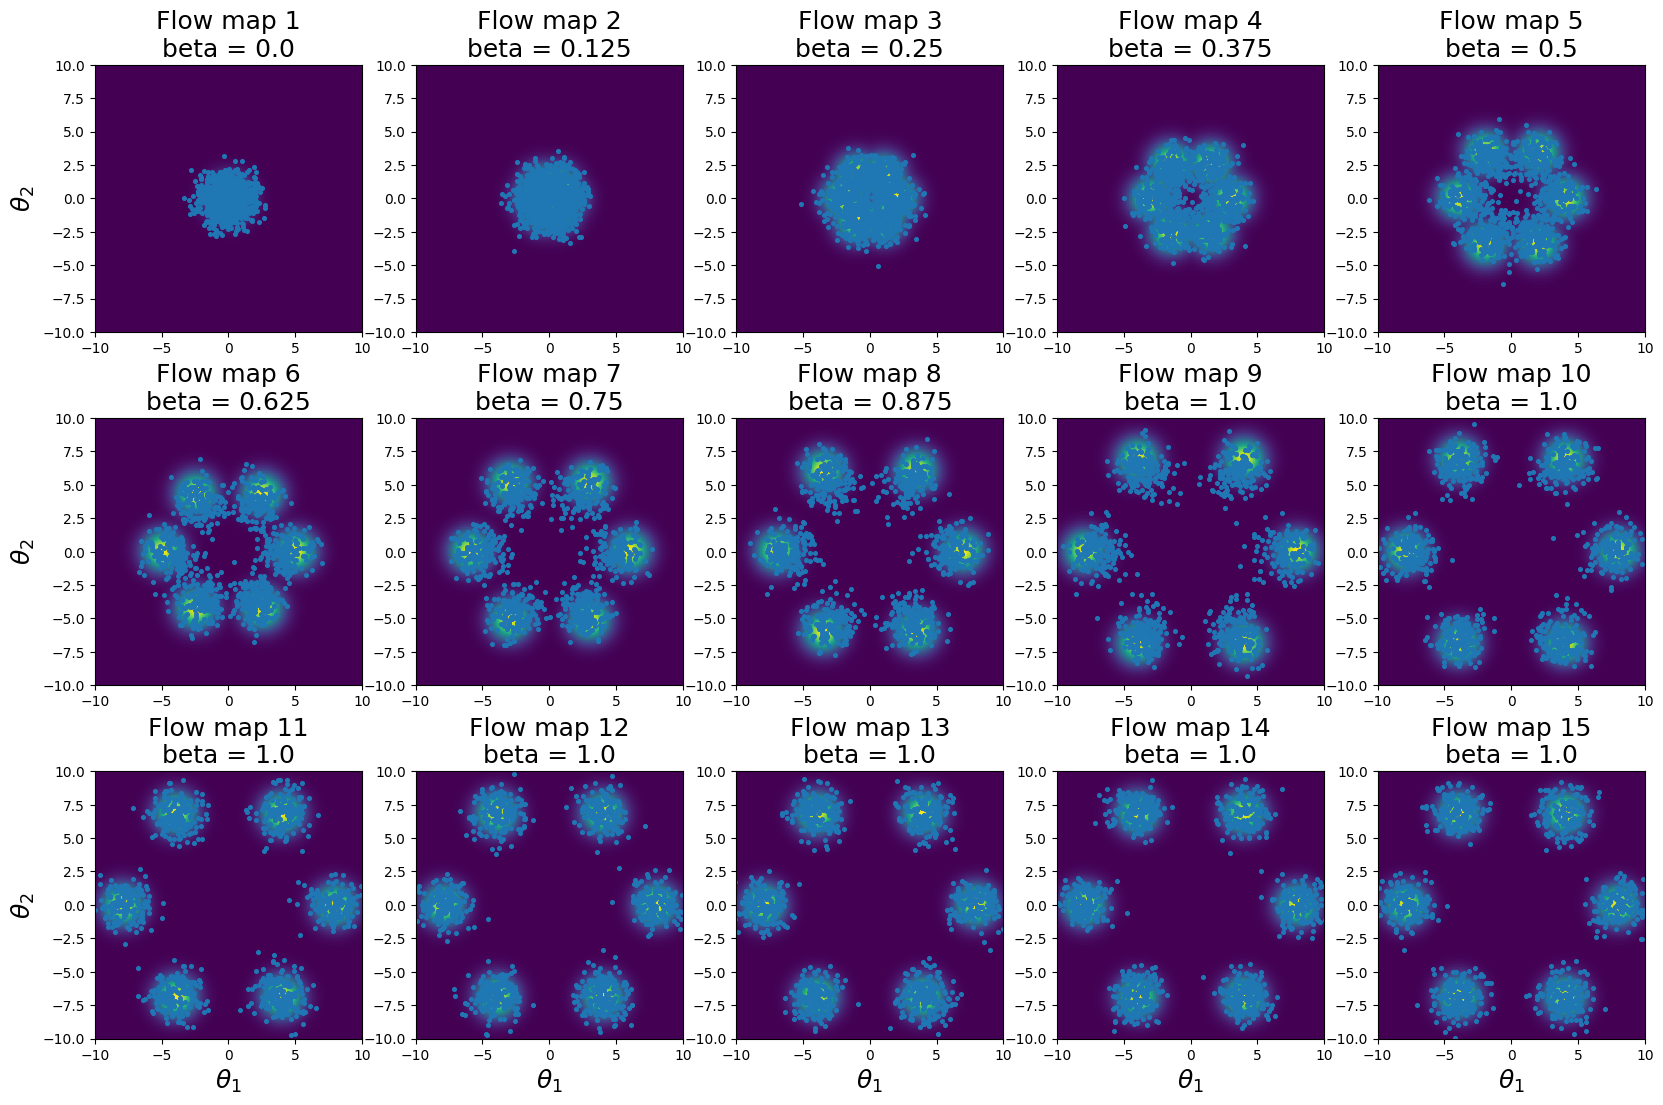

In [126]:
x_coords = np.linspace(-10, 10, 100)
y_coords = np.linspace(-10, 10, 100)
xs = np.array([[x, y] for y in y_coords for x in x_coords])
ys = target(xs)
fig, axs = plt.subplots(3,5, figsize=(20,13))
for idx, beta in enumerate(beta_schedule[:-1]):
    row = idx // 5
    col = idx % 5
    ax = axs[row, col]
    pdf = getUnnormalizedIntermediate(beta, initial, target)
    ax.imshow(pdf(xs).reshape(100,100), extent=[-10,10,-10,10])
    ax.scatter(all_samples[idx][:,0], all_samples[idx][:,1], alpha=1, s=7)
    if row == 2:
        ax.set_xlabel(r"$\theta_1$", fontsize=18)
    if col == 0:
        ax.set_ylabel(r"$\theta_2$", fontsize=18)
    ax.set_title(f"Flow map {idx+1}\nbeta = {beta}", fontsize=18)
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
plt.savefig('ais_rad.png')

In [24]:
effective_sample_size(weights)

4.3319260364504215

In [90]:
target = getTruncatedGaussian2D(3)
initial = multivariate_normal(np.array([0,0]), np.eye(2)).pdf
samples, weights, all_samples = AIS(beta_schedule, target, init_mean=np.array([0,0]), init_var=np.eye(2), n=1000, k=20)

/tmp/ipykernel_100/3114138485.py:19: RuntimeWarning: divide by zero encountered in log
  log_weights += np.log(intermediate_pdf(samples))
/tmp/ipykernel_100/3545992443.py:18: RuntimeWarning: divide by zero encountered in divide
  aux = u < new_probs/old_probs
/tmp/ipykernel_100/3545992443.py:18: RuntimeWarning: invalid value encountered in divide
  aux = u < new_probs/old_probs
/tmp/ipykernel_100/3114138485.py:22: RuntimeWarning: divide by zero encountered in log
  log_weights -= np.log(intermediate_pdf(samples))
/tmp/ipykernel_100/3114138485.py:22: RuntimeWarning: invalid value encountered in subtract
  log_weights -= np.log(intermediate_pdf(samples))
/tmp/ipykernel_100/3114138485.py:25: RuntimeWarning: divide by zero encountered in log
  log_weights += np.log(intermediate_pdf(samples))


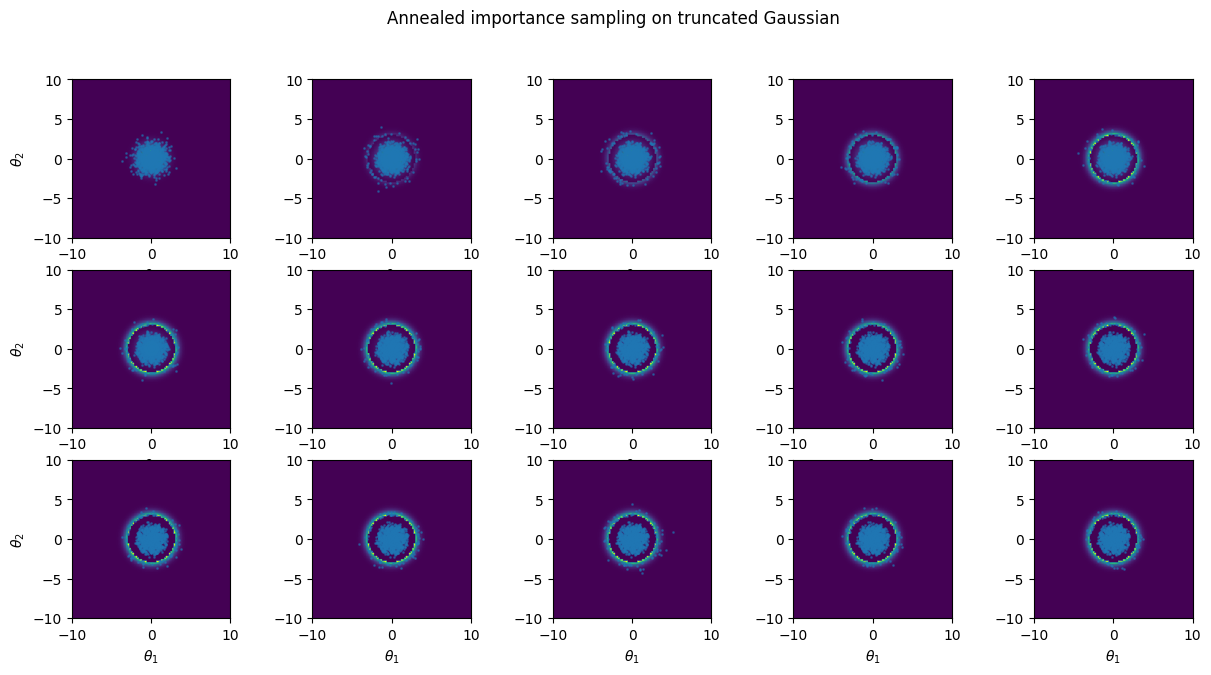

In [91]:
x_coords = np.linspace(-10, 10, 100)
y_coords = np.linspace(-10, 10, 100)
xs = np.array([[x, y] for y in y_coords for x in x_coords])
ys = target(xs)
fig, axs = plt.subplots(3,5, figsize=(15,7))
for idx, beta in enumerate(beta_schedule[:-1]):
    row = idx // 5
    col = idx % 5
    ax = axs[row, col]
    pdf = getUnnormalizedIntermediate(beta, initial, target, compose_type='lin')
    ax.imshow(pdf(xs).reshape(100,100), extent=[-10,10,-10,10])
    ax.scatter(all_samples[idx][:,0], all_samples[idx][:,1], alpha=0.5, s=1)
    ax.set_xlabel(r"$\theta_1$")
    if col == 0:
        ax.set_ylabel(r"$\theta_2$")
    fig.suptitle(r"Annealed importance sampling on truncated Gaussian")

Text(0, 0.5, '$\\theta_2$')

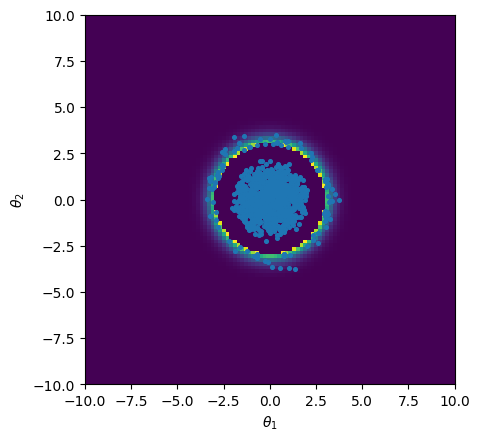

In [110]:
plt.scatter(samples[:,0], samples[:,1], alpha=1, s=7)
plt.imshow(target(xs).reshape(100,100), extent=[-10,10,-10,10])
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")

In [95]:
effective_sample_size(weights[~np.isnan(weights)])

10.999999999999998

/tmp/ipykernel_92/3545992443.py:18: RuntimeWarning: divide by zero encountered in divide
  aux = u < new_probs/old_probs
/tmp/ipykernel_92/3545992443.py:18: RuntimeWarning: invalid value encountered in divide
  aux = u < new_probs/old_probs


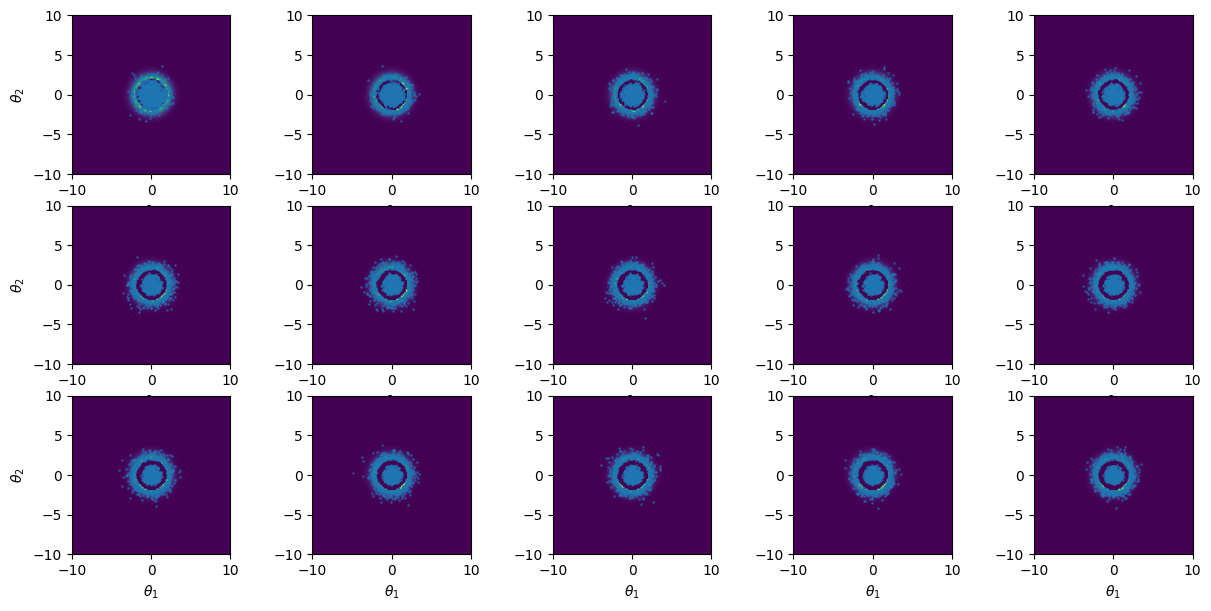

In [30]:
samples = multivariate_normal.rvs(np.array([0,0]), np.eye(2), 1000).reshape((1000,2))
fig, axs = plt.subplots(3,5, figsize=(15,7))

for i in range(15):
    row = i // 5
    col = i % 5
    ax = axs[row, col]
    ax.imshow(target(xs).reshape(100,100), extent=[-10,10,-10,10])
    ax.scatter(samples[:,0], samples[:,1], alpha=0.5, s=1)
    for _ in range(10):
        samples = gaussianDriftMH(samples, beta_schedule[-1], initial, target)
    ax.set_xlabel(r"$\theta_1$")
    if col == 0:
        ax.set_ylabel(r"$\theta_2$")

In [31]:
samples, weights, all_samples = AIS([0.0, 1.0, 1.0], target, init_mean=np.array([0,0]), init_var=np.eye(2), n=1000, k=100, compose_type='lin')

/tmp/ipykernel_92/3114138485.py:19: RuntimeWarning: divide by zero encountered in log
  log_weights += np.log(intermediate_pdf(samples))
/tmp/ipykernel_92/3545992443.py:18: RuntimeWarning: divide by zero encountered in divide
  aux = u < new_probs/old_probs
/tmp/ipykernel_92/3545992443.py:18: RuntimeWarning: invalid value encountered in divide
  aux = u < new_probs/old_probs
/tmp/ipykernel_92/3114138485.py:22: RuntimeWarning: divide by zero encountered in log
  log_weights -= np.log(intermediate_pdf(samples))
/tmp/ipykernel_92/3114138485.py:22: RuntimeWarning: invalid value encountered in subtract
  log_weights -= np.log(intermediate_pdf(samples))
/tmp/ipykernel_92/3114138485.py:25: RuntimeWarning: divide by zero encountered in log
  log_weights += np.log(intermediate_pdf(samples))


In [32]:
effective_sample_size(weights[~np.isnan(weights)])

140.0

# NUTS Functions + Multicore Tests

### PyMC / PyTensor Synthetic Distribution Implementations

In [15]:
# Fritz
# Sets number of cores = parallel chains to use for NUTS
num_cores = 4
num_samples = 5016
# Set GMM and Trunc params
gmm_modes = 6
gmm_rad = 8
gmm_var = 1
trunc_c = 6
trunc_var = 1
# Tuning samples for NUTS
tune = 0 

In [18]:
# Equal mixture of n radial symmetric Gaussians in 2D with variance var 
def getRadGMM2DPT(n, r, var):
    with pm.Model() as model:
        w = pm.ConstantData("w", np.full(n, 1/n))
        angs = np.linspace(0, 2*np.pi*((n-1)/n),n)
        means = pm.ConstantData("means", r * np.c_[np.cos(angs), np.sin(angs)])
        covs = pm.ConstantData("covs", np.full((n,2,2), var) * np.eye(2))
        
        mix = pm.Mixture("mix", w=w, comp_dists=pm.MvNormal.dist(mu=means, cov=covs, shape=(n,2)))

        # Total num samples = num chains = cores * draws
        trace = pm.sample(draws=math.ceil(float(num_samples)/num_cores), cores = num_cores, progressbar=True, tune=tune)

        samples = trace.posterior["mix"].values
        x_samples = samples[..., 0].flatten()
        y_samples = samples[..., 1].flatten()

        az.plot_kde(x_samples, y_samples, contour=True)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("2D KDE of NUTS Samples from Mixture Model")
        plt.show()

    return trace


/root/venv/lib/python3.10/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
/root/venv/lib/python3.10/site-packages/pytensor/link/c/cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mix]


/root/venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 0 tune and 1_254 draw iterations (0 + 5_016 draws total) took 47 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


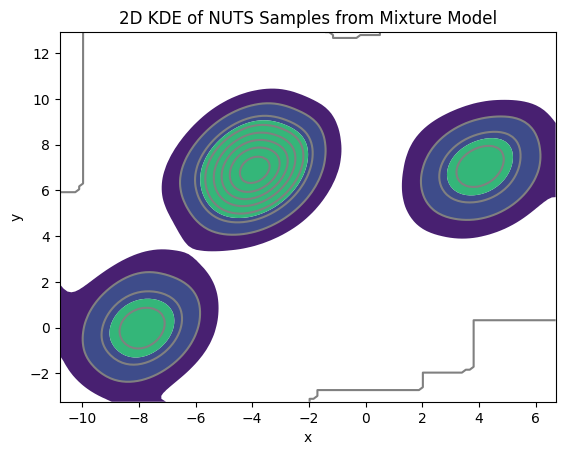

In [21]:
# Test getRadGMM2DPT
trace6gmm = getRadGMM2DPT(gmm_modes,gmm_rad,gmm_var)

# Total Samples Across Chains:  5016
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mix[0] -3.018  4.456  -9.148    5.089      2.172    1.118       5.0      30.0   
mix[1]  5.224  3.158  -1.146    8.769      1.494    0.818       7.0      35.0   

        r_hat  
mix[0]   2.39  
mix[1]   1.53  
/tmp/ipykernel_116/650557219.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[i][j] = pdf(np.array([[x[i],y[j]]]))


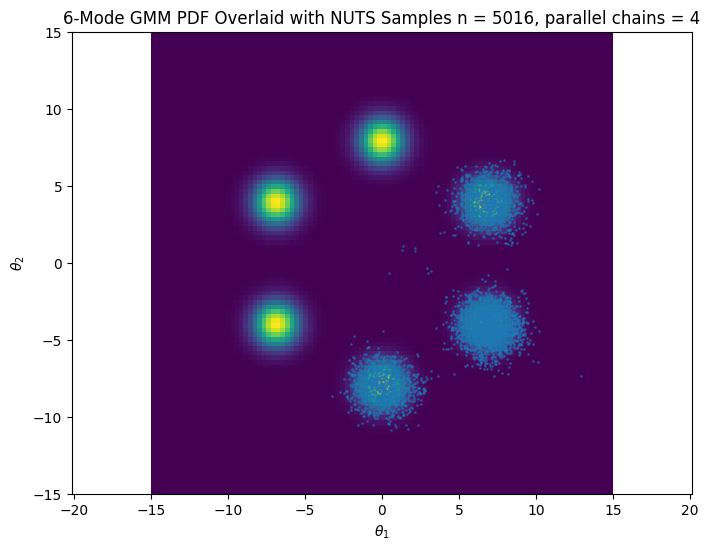

In [22]:
# Create Overlaid Heatmap with NUTS samples

samples6 = trace6gmm.posterior["mix"].values
y_samples6 = samples6[..., 0].flatten()
x_samples6 = samples6[..., 1].flatten()

print("# Total Samples Across Chains: ", len(x_samples6))
ess6 = az.ess(trace6gmm)
#print("ESS: ", ess6)

summary6 = az.summary(trace6gmm)
print(summary6)

gmm6ol = getRadGMM2D(gmm_modes,gmm_rad,gmm_var)

fig6ol, ax6ol = plotSquareHeatmap2D(gmm6ol, 100, -15, 15)
ax6ol.scatter(x_samples6, y_samples6, alpha=0.5, s=1)

for ax in fig6ol.axes:
    if hasattr(ax, 'get_label') and 'colorbar' in ax.get_label():
        fig6ol.delaxes(ax)

ax6ol.set_title(f"6-Mode GMM PDF Overlaid with NUTS Samples n = {len(x_samples6)}, parallel chains = {num_cores}")
fig6ol.show()

In [23]:
# 1D Mixture of Gaussians
def getGMM1DPT(weights, means, vs): # Numpy array input
    with pm.Model() as model:
        w = pm.ConstantData("w", weights)
        mu = pm.ConstantData("mu", means)
        tau = pm.ConstantData("tau", np.reciprocal(vs))
        
        mix = pm.NormalMixture("mix", w=w, mu=mu, tau=tau)
        trace = pm.sample(draws = math.ceil(float(num_samples)/num_cores), cores = num_cores, progressbar=True, tune=tune)

        ess = az.ess(trace)
        #print("ESS: ", ess)
        #summary = az.summary(trace, stat_focus="ess")
        #print(summary)
        az.plot_posterior(trace)

    return trace

In [24]:
# Test 1D mixture
#trace1dgmm =getGMM1DPT(np.array([2.0, 1.0])/3.0, np.array([-5.0,5.0]), np.array([1.0, 1.0]))

In [25]:
# 2D Truncated Gaussian
def getTruncGaussian2DPT(c, var = 1):
    """
    c: Truncation Radius
    var: Variance
    """
    with pm.Model() as model:
        def logp(value: TensorVariable, c: TensorVariable, var: TensorVariable) -> TensorVariable:
            norm = pt.constant(2*np.pi)*var*pt.exp(-c**2/(2*var))
            logp = -pt.nlinalg.norm(value)**2/(2*var) - pt.log(norm)
            logp = pt.switch(pt.nlinalg.norm(value) < c, -27, logp)
            return logp
        c = pm.ConstantData("c", c)
        var = pm.ConstantData("var", var)
        truncNorm = pm.CustomDist("truncNorm", c, var, logp=logp, shape=(1,2), dims=("x1", "x2"))

        trace = pm.sample(draws = math.ceil(float(num_samples)/num_cores), cores = num_cores, progressbar=True, tune = tune)

        samples = trace.posterior["truncNorm"].values
        x_samples = samples[..., 0].flatten()
        y_samples = samples[..., 1].flatten()

        az.plot_kde(x_samples, y_samples, contour=True)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("2D KDE of NUTS Samples from Truncated 2D Normal")
        plt.show()
    return trace

/root/venv/lib/python3.10/site-packages/pymc/data.py:235: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [truncNorm]


/root/venv/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 0 tune and 1_254 draw iterations (0 + 5_016 draws total) took 11 seconds.


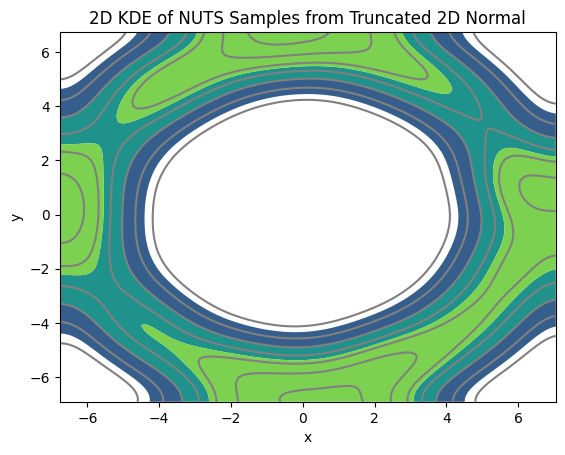

In [26]:
# Test 2D Truncated Gaussian
trace2dtrunc = getTruncGaussian2DPT(trunc_c,trunc_var)

# Total Samples Across Chains:  5016
                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
truncNorm[0, 0]  0.218  4.266  -6.076    6.122      0.187    0.061     507.0   
truncNorm[0, 1] -0.074  4.432  -6.130    6.136      0.192    0.059     527.0   

                 ess_tail  r_hat  
truncNorm[0, 0]     456.0   1.01  
truncNorm[0, 1]     712.0   1.01  
/tmp/ipykernel_116/650557219.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[i][j] = pdf(np.array([[x[i],y[j]]]))


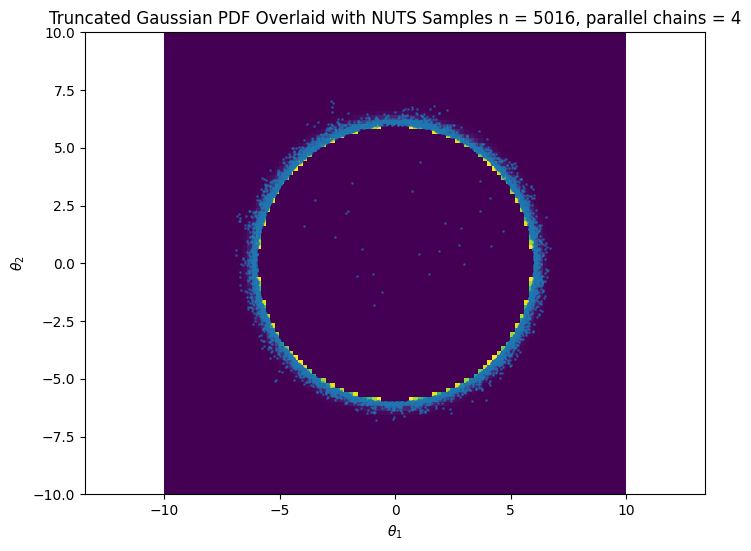

In [27]:
# Create Overlaid Heatmap with NUTS samples

samplestrunc = trace2dtrunc.posterior["truncNorm"].values
y_samplestrunc = samplestrunc[..., 0].flatten()
x_samplestrunc = samplestrunc[..., 1].flatten()

print("# Total Samples Across Chains: ", len(x_samplestrunc))
esstrunc = az.ess(trace2dtrunc)
#print("ESS: ", esstrunc)

summarytrunc = az.summary(trace2dtrunc)
print(summarytrunc)

gmmtruncol = getTruncatedGaussian2D(trunc_c,trunc_var)

figtruncol, axtruncol = plotSquareHeatmap2D(gmmtruncol, 100, -10, 10)
axtruncol.scatter(x_samplestrunc, y_samplestrunc, alpha=0.5, s=1)

for ax in figtruncol.axes:
    if hasattr(ax, 'get_label') and 'colorbar' in ax.get_label():
        figtruncol.delaxes(ax)

axtruncol.set_title(f"Truncated Gaussian PDF Overlaid with NUTS Samples n = {len(x_samplestrunc)}, parallel chains = {num_cores}")
figtruncol.show()

# Plot Synthetic Distributions

/tmp/ipykernel_116/650557219.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[i][j] = pdf(np.array([[x[i],y[j]]]))


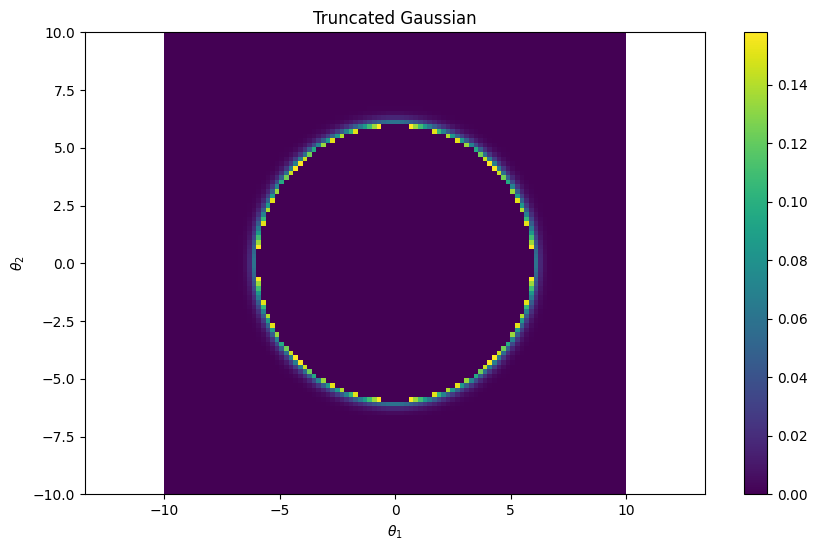

In [28]:
# Plot Truncated Gaussian
truncGmm = getTruncatedGaussian2D(6,1)

figTrunc, axTrunc = plotSquareHeatmap2D(truncGmm, 100, -10, 10)
axTrunc.set_title('Truncated Gaussian')
figTrunc.show()

/tmp/ipykernel_116/650557219.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out[i][j] = pdf(np.array([[x[i],y[j]]]))


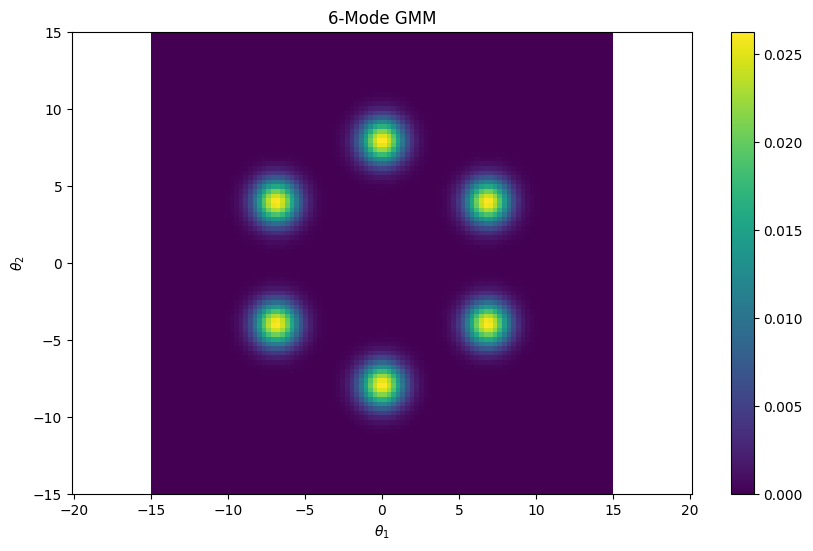

In [29]:
# Plot 6-Mode Radial GMM
gmm6 = getRadGMM2D(6,8,1)

fig6, ax6 = plotSquareHeatmap2D(gmm6, 100, -15, 15)
ax6.set_title('6-Mode GMM')
fig6.show()